# TFcomb main tutorial

This notebook describes the main function of TFcomb to identify the reprogramming TFs from source state to target state. We also provided multiple visualization examples in this tutorial.

## import

In [1]:
import torch
import os
import scanpy as sc
import celloracle as co
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import TFcomb as tfc

In [3]:
import importlib
import TFcomb
importlib.reload(TFcomb.preprocessing.pca_umap)
importlib.reload(TFcomb.preprocessing.oracle_process)
importlib.reload(TFcomb.tools.utils)
importlib.reload(TFcomb.tools.GRN_func)
importlib.reload(TFcomb.tools.GNN_module)
importlib.reload(TFcomb.tools.link_recover)
importlib.reload(TFcomb.tools.link_recover_module)
importlib.reload(TFcomb.tools.tf_inference)
importlib.reload(TFcomb.plotting.plot)
importlib.reload(TFcomb.plotting.plot_grn)

<module 'TFcomb.plotting.plot_grn' from '/nfs/public/lichen/code/TFcomb_github_doc/TFcomb/TFcomb/plotting/plot_grn.py'>

## Read processed adata

In [4]:
data_dir = '../../data/iPSC_example/RNA_data'
save_dir = '../../data/iPSC_example/save' # create the folder to save results
os.makedirs(save_dir,exist_ok=True)

adata = sc.read(os.path.join(data_dir,'adata_rna.h5ad'))

# - ensure the cluster_name
cluster_name = 'celltype'

# - print basic info of the adata
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")
print('the cluster_name count is:')
adata.obs[cluster_name].value_counts()

Cell number is :7841
Gene number is :1838
the cluster_name count is:


Fibroblasts    4665
iPSCs          3176
Name: celltype, dtype: int64

## Load base GRN & create celloracle object

In [5]:
# - load base GRN
base_GRN = pd.read_parquet(os.path.join('../../data/iPSC_example/base_GRN',"base_GRN_dataframe_stream.parquet"))
print(f"the base_GRN shape is {base_GRN.shape}")


# - train a pca and umap on the adata first, and input the adata to the oracle.
# the pca and umap model is for later visualize the transition
pca_train,umap_train, oracle = tfc.pp.pca_umap_train(adata,
                   cluster_column_name=cluster_name,
                   embedding_name="X_umap",
                   n_components=50,
                   svd_solver='arpack',
                   random_seed=2022)

the base_GRN shape is (31844, 1100)


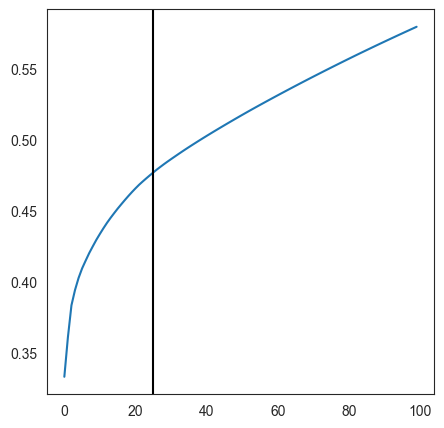

n_comps is: 25
cell number is :7841
Auto-selected k is :196
but we set default k is: 10


In [6]:
# - import the base_GRN to the oracle , and do the imputation
oracle.import_TF_data(TF_info_matrix=base_GRN)
oracle = tfc.pp.oracle_preprocess(oracle)
oracle.adata.obs['total'] = 'total'

## Construct a total GRN for all cells

  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for total...


  0%|          | 0/1617 [00:00<?, ?it/s]

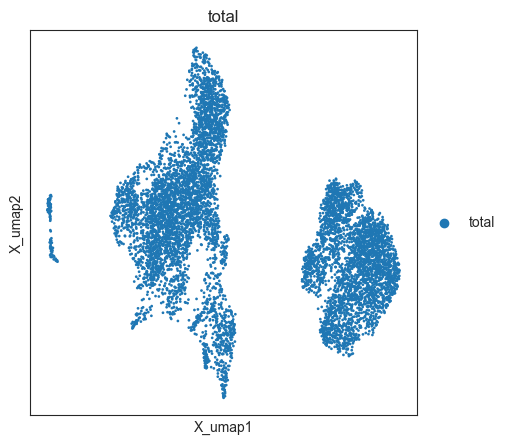

CPU times: user 2min 9s, sys: 12.1 s, total: 2min 21s
Wall time: 3min 9s


In [7]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.
cluster_name_for_GRN_unit = cluster_name
links = oracle.get_links(cluster_name_for_GRN_unit='total', 
                         alpha=10,
                         verbose_level=10) # 值得注意的在计算link的时候用的都是oracle.adata的imputed count

In [8]:
# save oracle and links
os.makedirs(os.path.join(save_dir, 'oracle'), exist_ok = True)
oracle.to_hdf5(os.path.join(save_dir, 'oracle', "data.celloracle.oracle"))
links.to_hdf5(file_path=os.path.join(save_dir, 'oracle', "links.celloracle.links"))

## Load saved oracle data and links

In [9]:
# - read oracle and links
oracle = co.load_hdf5(os.path.join(save_dir, 'oracle', "data.celloracle.oracle"))
links = co.load_hdf5(file_path=os.path.join(save_dir, 'oracle', "links.celloracle.links"))

# get the processed adata from oracle
adata = oracle.adata.copy() 
adata.X = adata.layers['normalized_count'].toarray()  # here we make the data sparse, not sure if there are problems

In [10]:
# - load total TF list from the base GRN
TFdict = tfc.tl.import_TF_data(TF_info_matrix=base_GRN)

tf_target_dict = {}
for target, gene_set in TFdict.items():
    for tf in gene_set:
        if tf not in tf_target_dict:
            tf_target_dict[tf] = []
            tf_target_dict[tf].append(target)
        else:
            tf_target_dict[tf].append(target)
total_tf_list = list(tf_target_dict.keys())
print('len of total_tf_list: ', len(total_tf_list))

len of total_tf_list:  1098


## Infer the results with TFcomb

### Init the parameters

In [11]:
adata.obs[cluster_name].value_counts()

Fibroblasts    4665
iPSCs          3176
Name: celltype, dtype: int64

In [12]:
# - set the ground-truth TFs
gt_tfs = ['POU5F1', 'MYC', 'SOX2', 'NANOG', 'KLF4']

# - set source_state and target_state
source_state, target_state = 'Fibroblasts', 'iPSCs'
combine = '_'.join([source_state, target_state])

# - init the save_dir to save results
save_dir_part = os.path.join(save_dir, combine)
os.makedirs(save_dir_part, exist_ok=True)

### Generate the CellOracle with only cells of source state and target state

In [ ]:
col_name = 'combine'
if not os.path.exists(os.path.join(save_dir_part,"data.celloracle.oracle")):
    oracle_part = oracle.copy()
    oracle_part.adata = oracle.adata[oracle.adata.obs[cluster_name].isin([source_state, target_state])]
    oracle_part.adata.obs[col_name] = '_'.join([source_state, target_state])
    oracle_part.adata.obs[col_name] = oracle_part.adata.obs[col_name].astype('category')
    oracle_part.cluster_column_name = col_name
    oracle_part.adata.uns[f'{col_name}_colors'] = np.array(['#ead3c6'])
    # Calculate GRN for each population in "louvain_annot" clustering unit.
    # This step may take some time.
    links_part = oracle_part.get_links(cluster_name_for_GRN_unit=col_name, 
                                alpha=10,
                                verbose_level=10)


    oracle_part.to_hdf5(os.path.join(save_dir_part, "data.celloracle.oracle"))
    links_part.to_hdf5(file_path=os.path.join(save_dir_part, "links.celloracle.links"))
else:
    oracle_part = co.load_hdf5(os.path.join(save_dir_part, "data.celloracle.oracle"))
    links_part = co.load_hdf5(file_path=os.path.join(save_dir_part, "links.celloracle.links"))

print('finish oracle_links_part load')

  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for Fibroblasts_iPSCs...


  0%|          | 0/1617 [00:00<?, ?it/s]

In [14]:
# set the link threshold and do inference again
threshold_number = 10000
alpha_fit_GRN = 10
links_part.filter_links(threshold_number=threshold_number,
                    p=0.001,
                    weight='coef_abs')
oracle_part.get_cluster_specific_TFdict_from_Links(links_object=links_part)
oracle_part.fit_GRN_for_simulation(alpha=alpha_fit_GRN,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# - get the GRN matrix
gene_GRN_mtx_ori, tf_GRN_mtx_ori, tf_GRN_dict_ori = tfc.tl.get_GRN_parameters(oracle_part, combine)

gene_GRN_mtx, tf_GRN_mtx = gene_GRN_mtx_ori, tf_GRN_mtx_ori

tf_list, gene_list = list(tf_GRN_mtx.index), list(tf_GRN_mtx.columns)

### Use GAT to enhance link [Optional]

This step is optional. If you suppose that your data has captured comprehensive regulatory links, you can skip this step.

The details of the gat_params can be refered at xxx.

In [16]:
gpu = 1
if torch.cuda.is_available():
    device='cuda'
    torch.cuda.set_device(gpu)
else:
    device='cpu'

gnn_params = {
    "n_splits": 10,
    "seed": 42,
    "neg_link_split": 'all',
    "model_name": 'GAT',
    "pred_name": 'mlp',
    "device": device
}

filter_params = {
    "count_fold": 9,
    "link_score_quantile": 0.1,
}

In [17]:
# - construct the graph dataset
adata_part = adata[adata.obs[cluster_name] == source_state]
dataset = tfc.tl.GRN_Dataset(adata_part, tf_GRN_mtx, tf_list)
graph = dataset[0]

print(graph)

save_dir_GNN = os.path.join(save_dir, 'GNN_result')
os.makedirs(save_dir_GNN, exist_ok=True)

Graph(num_nodes=1838, num_edges=10000,
      ndata_schemes={'feat': Scheme(shape=(4665,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


fold 0


 48%|████▊     | 716/1500 [00:29<00:32, 24.42it/s]


0.9674109999999998 0.907 0.907 0.907 0.907
EarlyStopping: run 717 epoch
AUC 0.9720469999999999
ACC 0.925
F1 0.925
precision 0.925
recall 0.925
the best epoch is 416
the best metric is 0.925


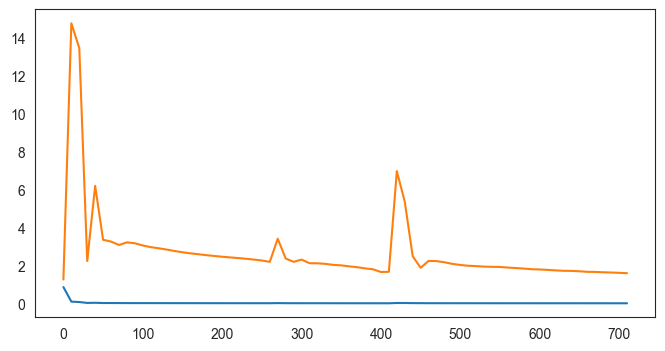

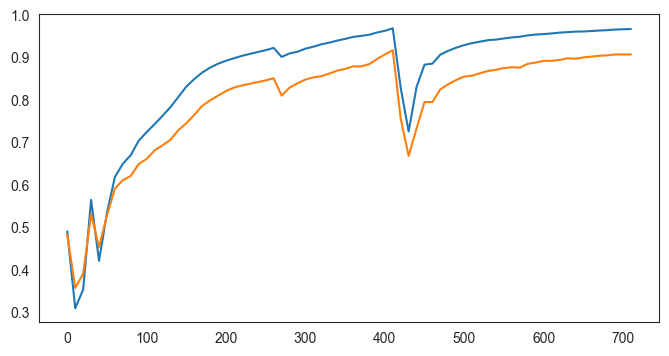

fold 1


100%|██████████| 1500/1500 [01:01<00:00, 24.45it/s]


AUC 0.99219
ACC 0.969
F1 0.969
precision 0.969
recall 0.969
the best epoch is 1314
the best metric is 0.969


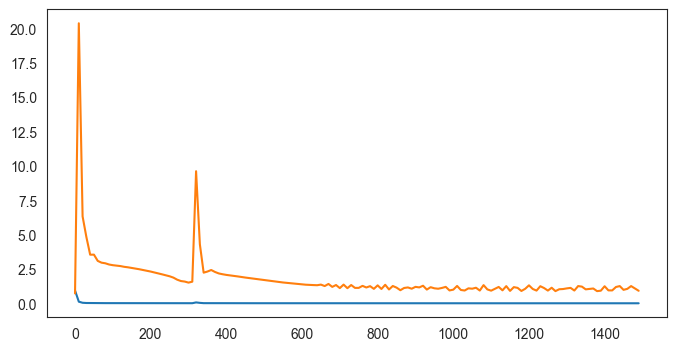

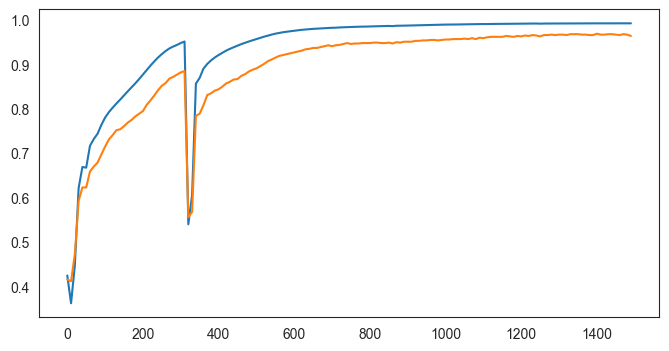

fold 2


 83%|████████▎ | 1244/1500 [00:51<00:10, 24.03it/s]


0.963508 0.9 0.9 0.9 0.9
EarlyStopping: run 1245 epoch
AUC 0.990194
ACC 0.969
F1 0.969
precision 0.969
recall 0.969
the best epoch is 944
the best metric is 0.969


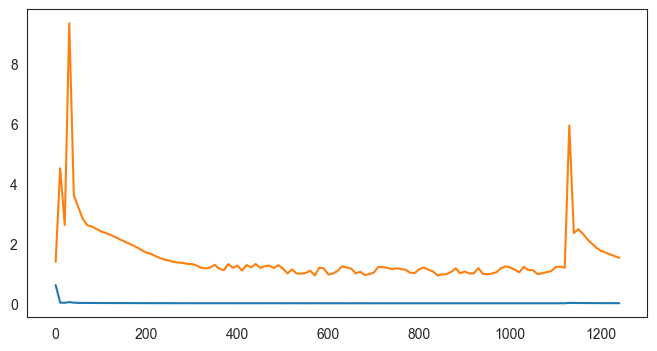

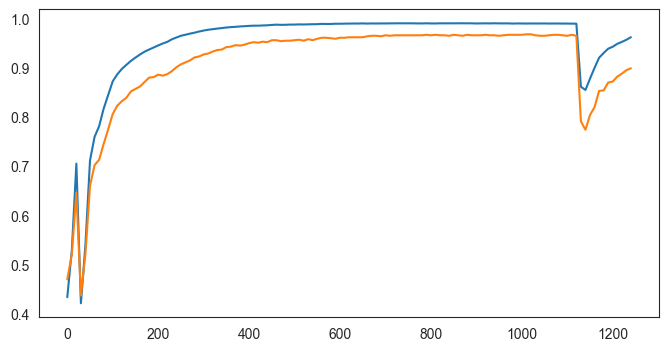

fold 3


 83%|████████▎ | 1244/1500 [00:51<00:10, 24.01it/s]


0.9851429999999999 0.96 0.96 0.96 0.96
EarlyStopping: run 1245 epoch
AUC 0.985783
ACC 0.962
F1 0.962
precision 0.962
recall 0.962
the best epoch is 944
the best metric is 0.962


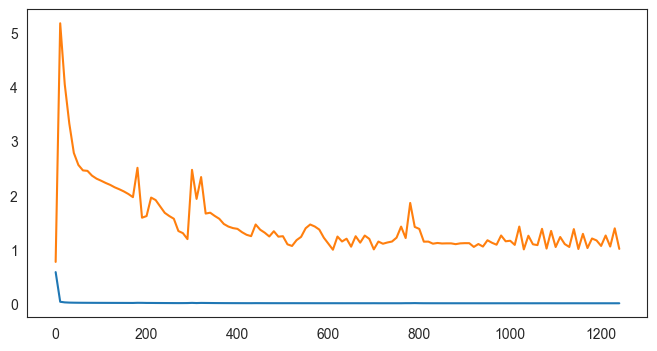

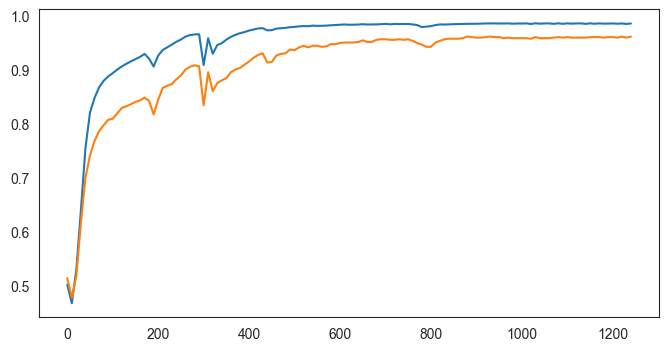

fold 4


100%|██████████| 1500/1500 [00:58<00:00, 25.57it/s]


AUC 0.9925719999999999
ACC 0.966
F1 0.966
precision 0.966
recall 0.966
the best epoch is 1490
the best metric is 0.966


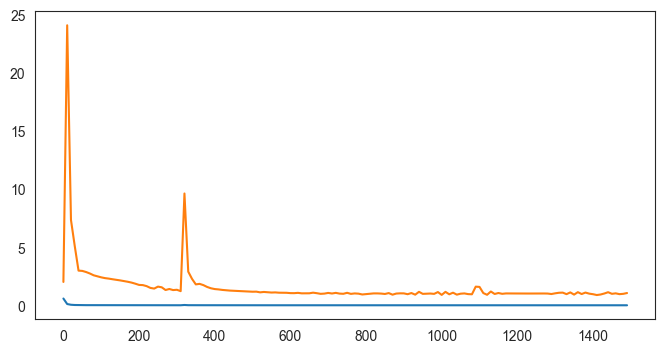

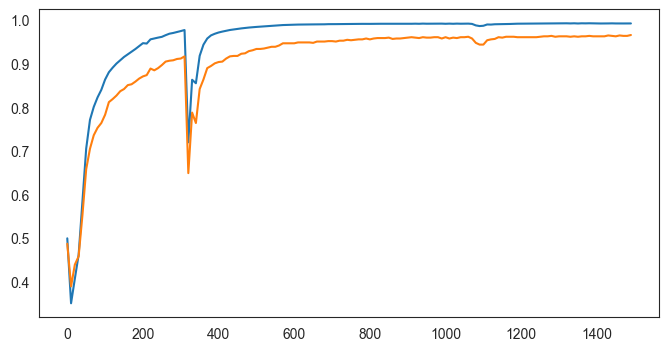

fold 5


 94%|█████████▍| 1412/1500 [00:55<00:03, 25.49it/s]


0.990106 0.951 0.951 0.951 0.951
EarlyStopping: run 1413 epoch
AUC 0.9951089999999999
ACC 0.974
F1 0.974
precision 0.974
recall 0.974
the best epoch is 1112
the best metric is 0.974


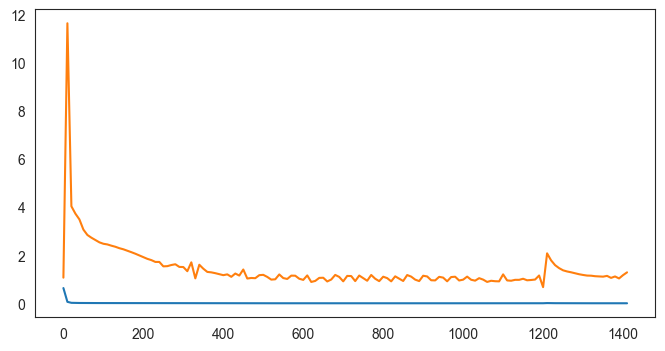

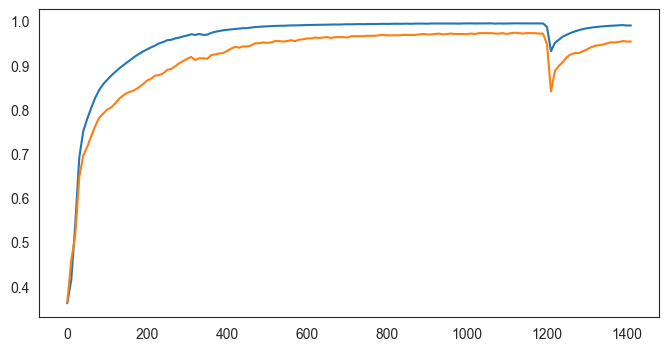

fold 6


 85%|████████▍ | 1272/1500 [00:53<00:09, 23.70it/s]


0.971593 0.921 0.9209999999999999 0.921 0.921
EarlyStopping: run 1273 epoch
AUC 0.975551
ACC 0.928
F1 0.928
precision 0.928
recall 0.928
the best epoch is 972
the best metric is 0.928


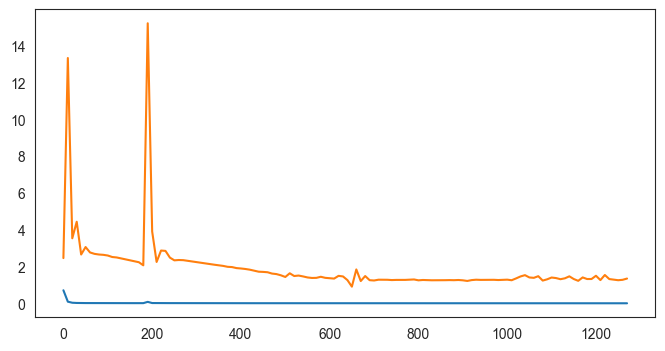

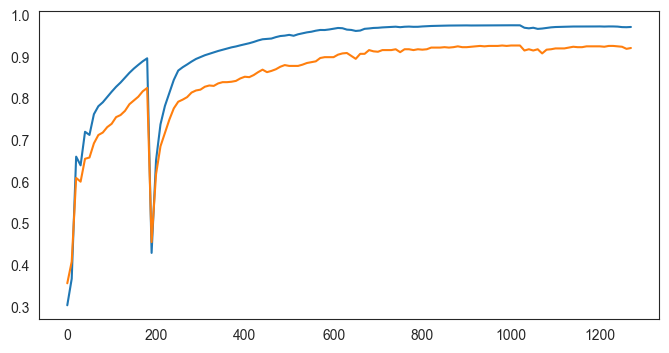

fold 7


 82%|████████▏ | 1223/1500 [00:51<00:11, 23.76it/s]


0.990264 0.961 0.961 0.961 0.961
EarlyStopping: run 1224 epoch
AUC 0.991066
ACC 0.964
F1 0.964
precision 0.964
recall 0.964
the best epoch is 923
the best metric is 0.964


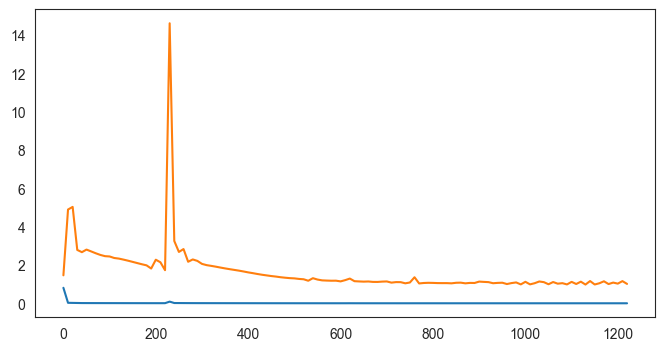

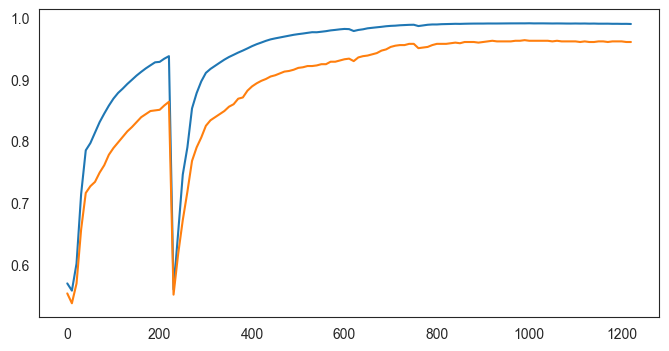

fold 8


100%|██████████| 1500/1500 [01:02<00:00, 23.87it/s]


AUC 0.981836
ACC 0.965
F1 0.965
precision 0.965
recall 0.965
the best epoch is 1284
the best metric is 0.965


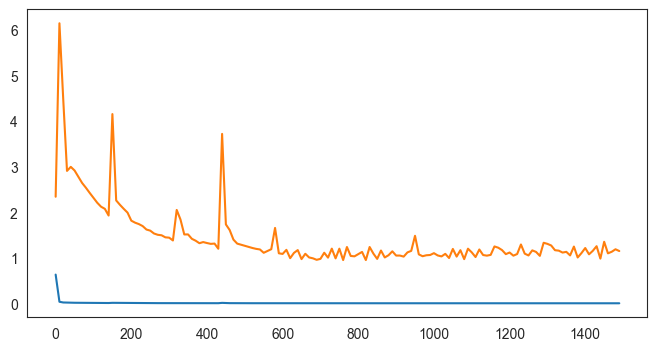

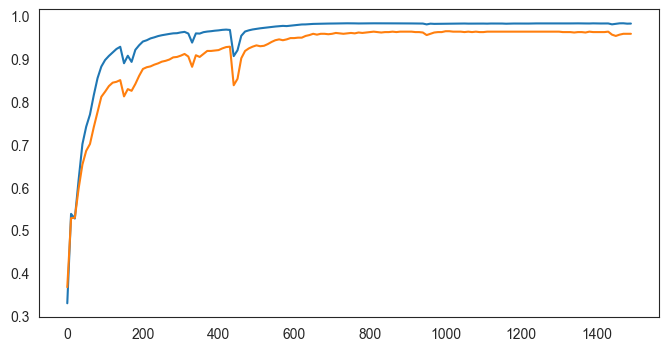

fold 9


 80%|███████▉  | 1196/1500 [00:49<00:12, 24.27it/s]


0.975033 0.934 0.934 0.934 0.934
EarlyStopping: run 1197 epoch
AUC 0.979327
ACC 0.94
F1 0.94
precision 0.94
recall 0.94
the best epoch is 896
the best metric is 0.94


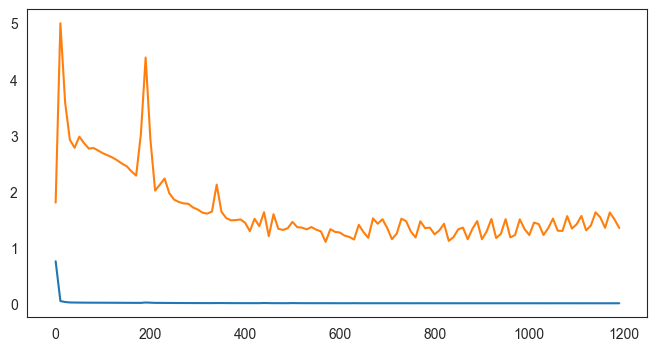

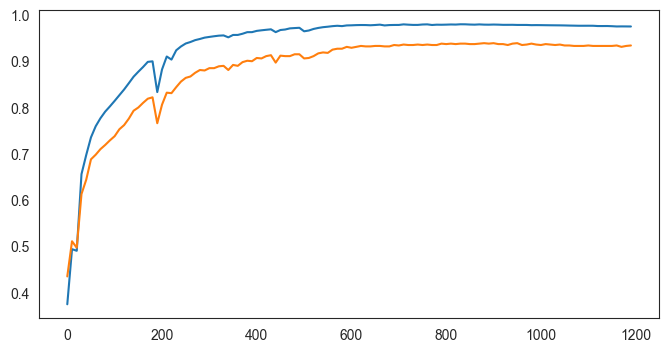

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
# - run GAT_recover_links
gene_GRN_mtx, tf_GRN_mtx, tf_GRN_dict, links_recover = tfc.tl.GAT_recover_links(
                    g = graph,
                    save_dir_GNN = save_dir_GNN,
                    tf_list = tf_list,
                    gene_list = gene_list,
                    tf_GRN_dict = tf_GRN_dict_ori,
                    oracle_part = oracle_part,
                    links_part = links_part,
                    combine = combine,
                    
                    **gnn_params,
                    **filter_params,
)

In [19]:
# - updata tf list and gene list
tf_list, gene_list = list(tf_GRN_mtx.index), list(tf_GRN_mtx.columns)

### Solve the inverse problem and obtain the expected alterations

In [20]:
# - init the save_dir to save figures
save_dir_fig = os.path.join(save_dir, 'figures')
os.makedirs(save_dir_fig, exist_ok=True)

tf_infer_params = {
    "layer_use": 'normalized_count',
    "model": 'ridge',
    "alpha": 1,
    "a1": 0.6,
    "a2": 0.2,
    "a3": 0.2,
    "save": os.path.join(save_dir_fig,'regression_coef.png')
}

==========model:ridge, alpha:1
correlation is: 0.9670431894372405


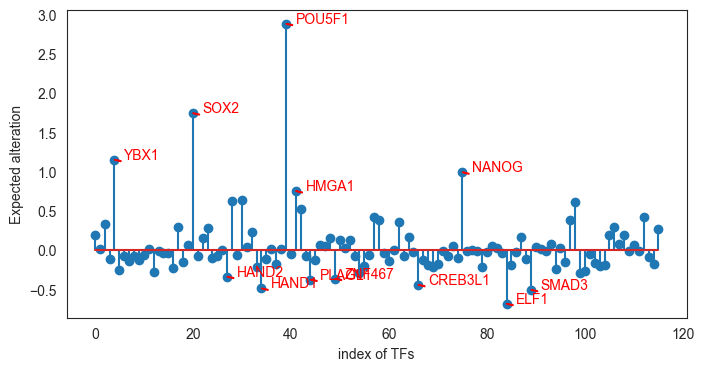

In [21]:
plt.rcParams["figure.figsize"] = [8, 4]
rr, X, source_ave, target_ave = tfc.tl.TF_inference(
                adata,
                cluster_name,
                tf_list,
                tf_GRN_mtx,
                gene_GRN_mtx,
                tf_GRN_mtx_ori,
                gene_GRN_mtx_ori,
                source_state,
                target_state,
                **tf_infer_params)

### Obtain directing scores

In [22]:
TF_ds_dict, _ = tfc.tl.get_directing_score(
                    tf_list,
                    rr,
                    tf_GRN_mtx,
                    tf_GRN_dict,
                    diff_ave = (target_ave - source_ave).ravel(),
                    )

### Plot results

First, we calculate the DE genes to annotate in our figures.

In [23]:
pos_genes, neg_genes, pos_tfs, neg_tfs = tfc.tl.get_de_genes(
                    adata,
                    cluster_name,
                    source_state,
                    target_state,
                    tf_list,
                    p_val=0.05)

Plot the scatter plots to show the directing scores and expected alterations for all TFs.

In [24]:
# - get the percentage to show TFs
x_name, y_name = 'Expected alteration', 'Directing score'
TF_number = 20 # top show TFs

df = pd.DataFrame({'index':tf_list + tf_list,
                    'value':list(rr.coef_) + list(TF_ds_dict.values()),
                    'cluster':[x_name]*len(rr.coef_) + [y_name]*len(rr.coef_)})

percentile = tfc.tl.get_percentile_thre(df, 'value', True, x_name, y_name, TF_number)

the percentile threshold is 75.0


In [25]:
plot_score_params = {
    "cluster1": x_name,
    "cluster2": y_name,
    "percentile1": percentile,
    "percentile2": percentile,
    "de_genes": list(pos_genes) + list(neg_genes),
    "gt_tfs": gt_tfs,
    "title": '->'.join([source_state, target_state]),
    "plot_all_tf": False,
    "goi_size": 10, 
    "point_size": 15,
    "save": os.path.join(save_dir_fig,'score.png'),
}

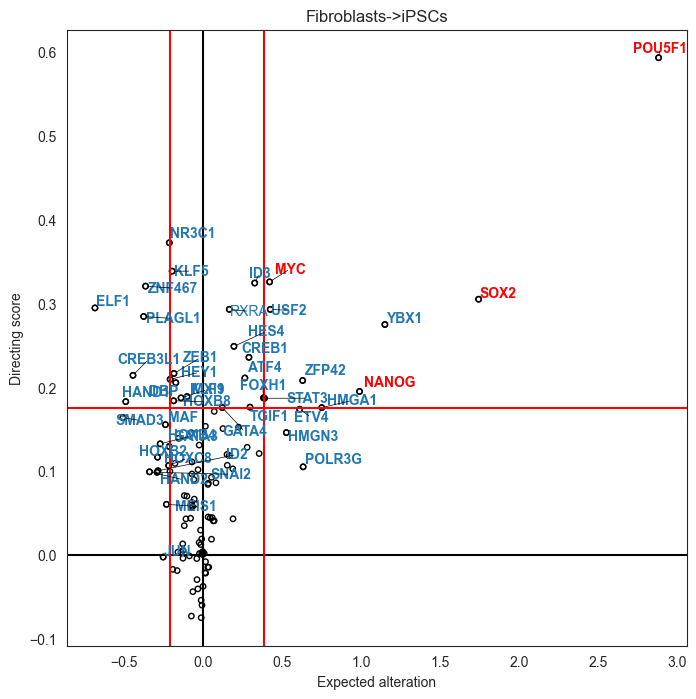

In [ ]:
plt.rcParams["figure.figsize"] = [8, 8]
change_tf = tfc.pl.plot_score_comparison(
                            df, 
                            value='value', 
                            **plot_score_params)

Plot GRN.

In [ ]:
# - get the score list, if you want to get the TFs for overexpression, set the direction to 'pos'
df_score = tfc.tl.get_single_TF(
    tf_list,
    rr,
    TF_ds_dict,
    direction = 'pos')
df_score.head()

,TF,directing_score,expected_alteration
0,POU5F1,0.593238,2.884884
1,MYC,0.325834,0.422007
2,ID3,0.324495,0.327827
3,SOX2,0.305168,1.745223
4,RXRA,0.293102,0.166871


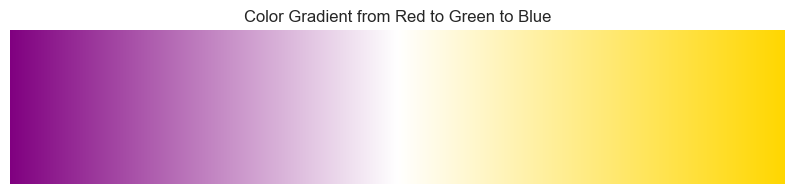

In [ ]:
gene_color_dict = tfc.pl.get_gene_color_dict(oracle_part,
                                      source_state)

In [29]:
# - get tf_GRN_dict_delta
tf_GRN_dict_delta = {}
for key_1, dict_1 in tf_GRN_dict.items():
    tf_GRN_dict_delta[key_1] = {key_2:value for key_2, value in dict_1.items() if key_2 not in tf_GRN_dict_ori[key_1]}

# - set plot TFs
plot_tf_list = list(df_score['TF'][0:10])    

recover_tf_list, recover_pair_list = [], []
for tf in plot_tf_list:
    recover_tf_list.extend(list(tf_GRN_dict_delta[tf].keys()))
    recover_pair_list.extend([f'{tf}_{target}' for target in list(tf_GRN_dict_delta[tf].keys())])
recover_tfs = np.unique(recover_tf_list)
    

Note: `pygraphviz` should be installed to plot the GRN. Refer [here](https://pygraphviz.github.io/documentation/stable/install.html) for the installation.

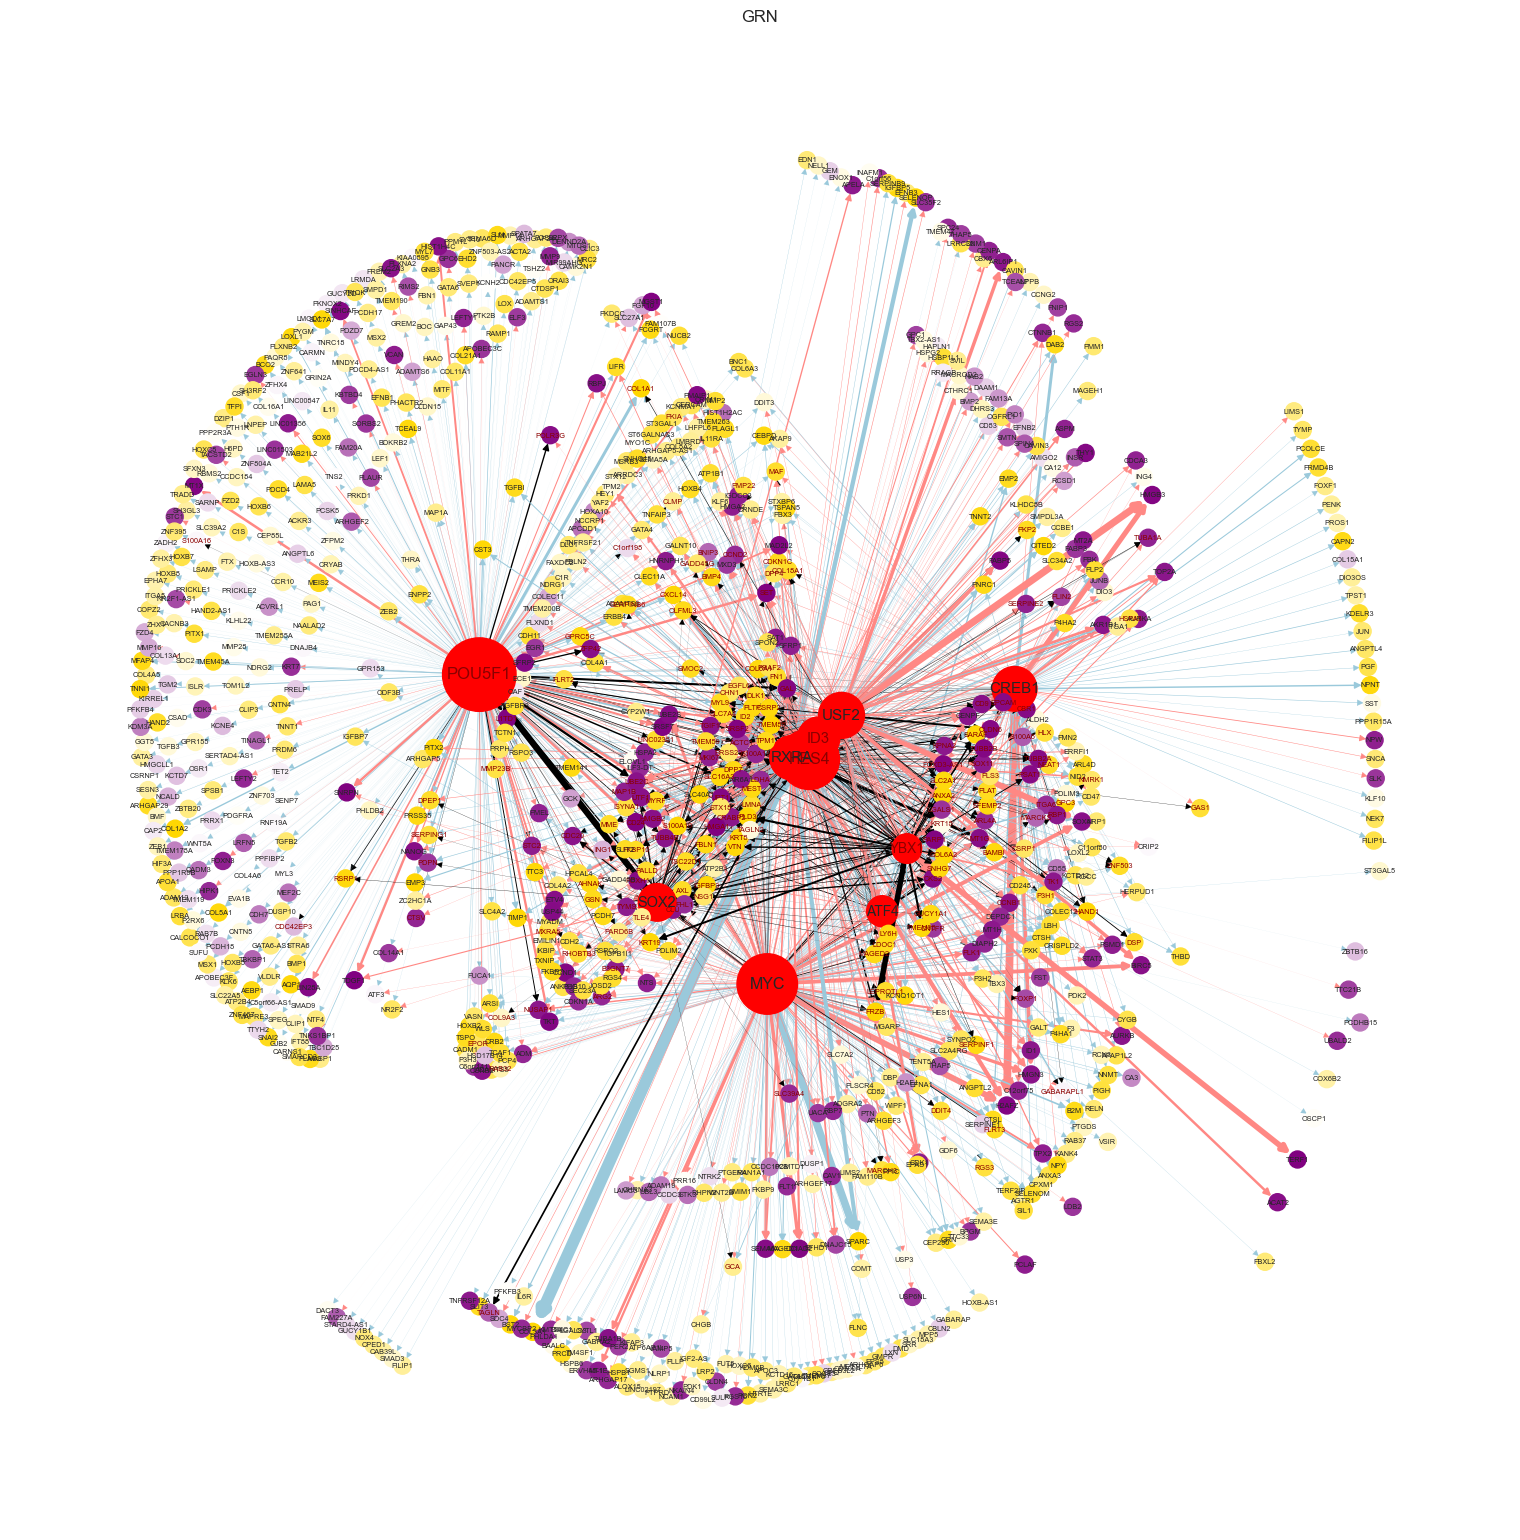

In [ ]:
tfc.pl.plot_GRN(tf_GRN_dict = tf_GRN_dict,
                plot_tf_list = plot_tf_list, # plot top 10 TFs 
                save_dir_GRN = os.path.join(save_dir_fig,'GRN.png'),
                filter_link = False,
                anno_tfs = recover_tfs,
                anno_edges = recover_pair_list,
                show_mode = True,
                figsize = (15,15),
                gene_color_dict = gene_color_dict)

### Calculate TIS score

In [31]:
tis_score = tfc.tl.get_benchmark_score(gt_tfs, plot_tf_list)
print('TIS is: ', tis_score)

TIS is:  0.5800000000000001


### Infer TF combiantions

In [ ]:
df_score_combo = tfc.tl.get_multi_TF(
    tf_list,
    rr,
    tf_GRN_mtx,
    tf_GRN_dict,
    source_ave,
    target_ave,
    direction = 'pos',
    number = 3)

100%|██████████| 17296/17296 [00:08<00:00, 2030.57it/s]


In [33]:
df_score_combo.head()

,TF_combination,directing_score
0,"(YBX1, SOX2, POU5F1)",0.706029
1,"(YBX1, POU5F1, NANOG)",0.702884
2,"(POU5F1, MYC, NANOG)",0.694539
3,"(SOX2, POU5F1, MYC)",0.694433
4,"(YBX1, POU5F1, MYC)",0.691140
